# Radiosensitivity Prediction with Support Vector Machine

In [1]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, SVR

In [2]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [3]:
def evaluation(clf, X, y):
    
    y_pred = clf.predict(X)
    y_pred_proba = clf.decision_function(X)

    fp_rates, tp_rates, _ = roc_curve(y, y_pred_proba)
    #ax.plot(fp_rates, tp_rates, label = str(fold))
    roc_auc = auc(fp_rates, tp_rates)

    accuracy  = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall    = recall_score(y, y_pred)
    f1        = f1_score(y, y_pred)
    roc_auc   = auc(fp_rates, tp_rates)
    confusion = confusion_matrix(y, y_pred)

    return [accuracy, precision, recall, f1, roc_auc, fp_rates, tp_rates, confusion]


## Preprocessing

In [4]:
sample_info = pd.read_csv('../data/sample_info.csv')
radiosensitivity = pd.read_csv('../data/radiosensitivity.csv')
expression = pd.read_csv('../data/expressionData.csv')

In [5]:
sc = StandardScaler()
radiosensitivity['sf2_scaled'] = sc.fit_transform(np.asarray(radiosensitivity['SF2']).reshape(-1,1))

std = radiosensitivity['sf2_scaled'].std()
mean = radiosensitivity['sf2_scaled'].mean()

for i in range(radiosensitivity.shape[0]):
    if radiosensitivity.at[i, 'sf2_scaled'] < mean - std * 0.8:
        radiosensitivity.at[i, 'Sensitivity'] = 'sensitive'
    elif radiosensitivity.at[i, 'sf2_scaled'] > mean + std * 0.8:
        radiosensitivity.at[i, 'Sensitivity'] = 'resistant'
    else:
        radiosensitivity.at[i, 'Sensitivity'] = 'intermediate'

data = pd.merge(radiosensitivity[['cell_line_name', 'Sensitivity']], expression, on='cell_line_name', how='inner')

In [6]:
data['Sensitivity'] = data['Sensitivity'].replace({'sensitive': 1, 'resistant': 0, 'intermediate': 2})
data = data.drop(data[data.Sensitivity == 2].index)
data.drop(columns=['cell_line_name'], inplace=True)

y = data['Sensitivity']
X = data.drop(columns=['Sensitivity'])

/scratch/tmp.32618.fschindele/ipykernel_2372704/1811356688.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Sensitivity'] = data['Sensitivity'].replace({'sensitive': 1, 'resistant': 0, 'intermediate': 2})


## ML models

### PCA + SVC, 5-fold CV

Working on fold 1
Train: 
[[73  7]
 [17 54]]
Test: 
[[18  2]
 [10  8]]
Working on fold 2
Train: 
[[73  7]
 [25 46]]
Test: 
[[16  4]
 [ 9  9]]
Working on fold 3
Train: 
[[80  0]
 [ 0 71]]
Test: 
[[13  7]
 [10  8]]
Working on fold 4
Train: 
[[80  0]
 [ 0 71]]
Test: 
[[15  5]
 [ 7 11]]
Working on fold 5
Train: 
[[71  9]
 [25 47]]
Test: 
[[17  3]
 [ 4 13]]


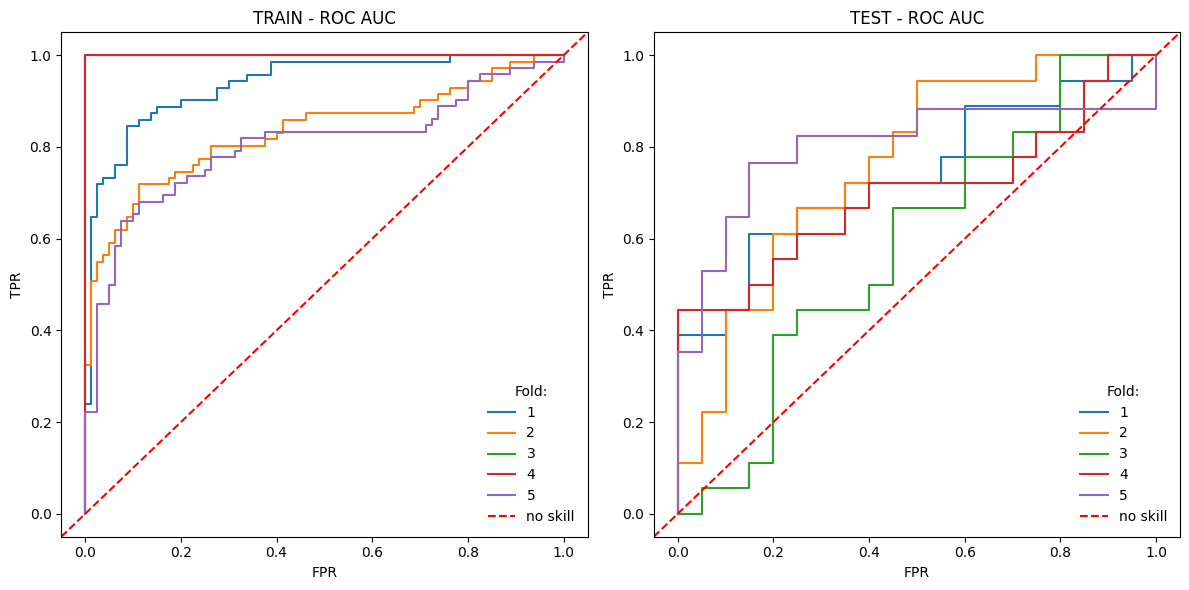

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
fold = 1

train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}
test_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'ROC AUC': []}
best_params = {'pca__n_components': [],
              'svc__C': [],
              'svc__gamma': []}

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(12,6))

param_grid = {'pca__n_components': np.linspace(5, 80, 5, dtype=int),
              'svc__C': [10**x for x in np.linspace(-3, 2, 5)],
              'svc__gamma': [10**x for x in np.linspace(-6, 0, 5)]}

for train_index, test_index in cv.split(X, y):
    print(f"Working on fold {fold}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    pipe = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA()),
                    ('svc', SVC(kernel='rbf', random_state=0))])
    search = GridSearchCV(pipe, 
                          param_grid, 
                          n_jobs=-1
                          , error_score='raise'
                          )
    clf = search.fit(X_train, y_train)

    #print("Best parameter (CV score=%0.3f):" % search.best_score_)
    #print(search.best_params_)
    #best_params['pca__n_components'].append(search.best_params_['pca__n_components'])
    #best_params['svc__C'].append(search.best_params_['svc__C'])
    for param in search.best_params_.keys():
        best_params[param].append(search.best_params_[param])

    train_eval = evaluation(clf, X_train, y_train)
    train_metrics['accuracy'].append(train_eval[0])
    train_metrics['precision'].append(train_eval[1])
    train_metrics['recall'].append(train_eval[2])
    train_metrics['f1'].append(train_eval[3])
    train_metrics['ROC AUC'].append(train_eval[4])
    
    ax0.plot(train_eval[5], train_eval[6], label = str(fold))

    test_eval = evaluation(clf, X_test, y_test)
    test_metrics['accuracy'].append(test_eval[0])
    test_metrics['precision'].append(test_eval[1])
    test_metrics['recall'].append(test_eval[2])
    test_metrics['f1'].append(test_eval[3])
    test_metrics['ROC AUC'].append(test_eval[4])
    
    ax1.plot(test_eval[5], test_eval[6], label = str(fold))

    print(f"Train: \n{train_eval[7]}")
    print(f"Test: \n{test_eval[7]}")

    fold += 1

ax0.set(title= 'TRAIN - ROC AUC',
       xlabel = 'FPR',
       ylabel ='TPR')
ax1.set(title= 'TEST - ROC AUC',
       xlabel = 'FPR',
       ylabel ='TPR')
add_identity(ax0, color="r", ls="--",label = 'no skill')
add_identity(ax1, color="r", ls="--",label = 'no skill')
ax0.legend(frameon=False, loc='lower right', title='Fold:')
ax1.legend(frameon=False, loc='lower right', title='Fold:')
plt.tight_layout()
plt.savefig("../output/SVM_ROC.pdf")

In [15]:
performance_train = pd.DataFrame(data=train_metrics, index=range(1, 6))
performance_train

,accuracy,precision,recall,f1,ROC AUC
1,0.841060,0.885246,0.760563,0.818182,0.936620
2,0.788079,0.867925,0.647887,0.741935,0.833275
3,1.000000,1.000000,1.000000,1.000000,1.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.776316,0.839286,0.652778,0.734375,0.803125


In [16]:
print(f"Performance averaged over 5 folds:")
for column in ['accuracy', 'precision', 'recall', 'f1', 'ROC AUC']:
    print(f"{column} = {performance_train[column].mean():.4f} ± {performance_train[column].std():.4f}")

Performance averaged over 5 folds:
accuracy = 0.8811 ± 0.1113
precision = 0.9185 ± 0.0762
recall = 0.8122 ± 0.1772
f1 = 0.8589 ± 0.1329
ROC AUC = 0.9146 ± 0.0923


In [17]:
param_grid

{'pca__n_components': array([ 5, 23, 42, 61, 80]),
 'svc__C': [0.001,
  0.01778279410038923,
  0.31622776601683794,
  5.623413251903491,
  100.0],
 'svc__gamma': [1e-06,
  3.1622776601683795e-05,
  0.001,
  0.03162277660168379,
  1.0]}

In [18]:
best_params = pd.DataFrame(data=best_params, index=range(1,6))
best_params

,pca__n_components,svc__C,svc__gamma
1,23,5.623413,0.000032
2,23,100.000000,0.000001
3,61,100.000000,0.000032
4,80,100.000000,0.000032
5,23,100.000000,0.000001


In [19]:
performance_test = pd.DataFrame(data=test_metrics, index=range(1, 6))
performance_test

,accuracy,precision,recall,f1,ROC AUC
1,0.684211,0.800000,0.444444,0.571429,0.741667
2,0.657895,0.692308,0.500000,0.580645,0.761111
3,0.552632,0.533333,0.444444,0.484848,0.583333
4,0.684211,0.687500,0.611111,0.647059,0.700000
5,0.810811,0.812500,0.764706,0.787879,0.800000


In [20]:
print(f"Performance averaged over 5 folds:")
for column in ['accuracy', 'precision', 'recall', 'f1', 'ROC AUC']:
    print(f"{column} = {performance_test[column].mean():.4f} ± {performance_test[column].std():.4f}")

Performance averaged over 5 folds:
accuracy = 0.6780 ± 0.0920
precision = 0.7051 ± 0.1124
recall = 0.5529 ± 0.1365
f1 = 0.6144 ± 0.1128
ROC AUC = 0.7172 ± 0.0831


#### Historic performance of the model

**param_grid** is probably wrong
param_grid = {'pca__n_components': [x for x in np.linspace(5, 80, 10)],
              'svc__C': [10**x for x in np.linspace(-4, 1, 10)],
              'svc__gamma': [10**x for x in np.linspace(-4, 1, 10)]}
              
|       | pca__n_components | svc__C | svc__gamma |
|-------|--------------------|--------|------------|
| **1** | 40                 | 0.1    | 0.1        |
| **2** | 40                 | 0.1    | 0.1        |
| **3** | 40                 | 0.1    | 0.1        |
| **4** | 40                 | 0.1    | 0.1        |
| **5** | 40                 | 0.1    | 0.1        |

| Metric     | Value               |
|------------|---------------------|
| Accuracy   | 0.5292 ± 0.0064     |
| Precision  | 0.0000 ± 0.0000     |
| Recall     | 0.0000 ± 0.0000     |
| F1         | 0.0000 ± 0.0000     |
| ROC AUC    | 0.5000 ± 0.0000     |

param_grid: {'pca__n_components': array([ 5, 23, 42, 61, 80]),
 'svc__C': [0.0001, 0.0031622776601683794, 0.1, 3.1622776601683795, 100.0],
 'svc__gamma': [1e-06, 3.1622776601683795e-05, 0.001, 0.03162277660168379, 1.0]}
 
 |       | pca__n_components | svc__C | svc__gamma |
|-------|--------------------|--------|------------|
| **1** | 80                 | 100.0  | 0.000032   |
| **2** | 23                 | 100.0  | 0.000001   |
| **3** | 61                 | 100.0  | 0.000032   |
| **4** | 23                 | 100.0  | 0.000001   |
| **5** | 23                 | 100.0  | 0.000001   |

| Metric     | Value               |
|------------|---------------------|
| Accuracy   | 0.6834 ± 0.0874     |
| Precision  | 0.7058 ± 0.1021     |
| Recall     | 0.5752 ± 0.1348     |
| F1         | 0.6278 ± 0.1077     |
| ROC AUC    | 0.7146 ± 0.0840     |

{'pca__n_components': array([ 5, 13, 22, 31, 40]),
 'svc__C': [10.0, 56.23413251903491, 316.22776601683796, 1778.2794100389228, 10000.0],
 'svc__gamma': [1e-06, 5.623413251903491e-06, 3.1622776601683795e-05, 0.00017782794100389227, 0.001]}
 
 |       | pca__n_components | svc__C    | svc__gamma |
|-------|--------------------|----------|------------|
| **1** | 13                 | 10.000000 | 0.000032   |
| **2** | 13                 | 316.227766 | 0.001000  |
| **3** | 40                 | 10.000000 | 0.000178   |
| **4** | 22                 | 56.234133 | 0.000001   |
| **5** | 22                 | 56.234133 | 0.000001   |

| Metric     | Value               |
|------------|---------------------|
| Accuracy   | 0.6306 ± 0.1064     |
| Precision  | 0.6394 ± 0.1228     |
| Recall     | 0.5529 ± 0.1670     |
| F1         | 0.5793 ± 0.1231     |
| ROC AUC    | 0.6713 ± 0.0908     |
